## Imports

In [1]:
import os
import random
import time
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import skimage.measure
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from numpy import cos, exp, sin, sqrt, tanh
from PIL import Image as im
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, utils

## Functions

In [2]:
class Timer:
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self.end = time.time()
        self.elapsed = divmod(self.end-self.start, 60)
        self.mins = int(self.elapsed[0])
        self.secs = float(f'{self.elapsed[1]:.2f}')

In [3]:
def random_kernel(kernel_size=3, seed=None, dim=2):
    assert kernel_size % 2 == 1, 'Kernel side length must be an odd number.'

    np.random.seed(seed)
    
    size = np.zeros((kernel_size,)*dim).shape

    kernel = np.random.randint(1, 13, size=size)

    return kernel

In [4]:
functions = [
        lambda x: x,  # Placeholder for 0, not used
        lambda x: sin(x),
        lambda x: cos(x),
        lambda x: sin(3 * x),
        lambda x: cos(3 * x),
        lambda x: sqrt(max(0, x)),
        lambda x: exp(-x),
        lambda x: sqrt(0.5 * x),
        lambda x: x ** 2,
        lambda x: x,
        lambda x: tanh(x),
        lambda x: exp(-2 * x),
        lambda x: 1 / (1 + exp(-x)),
    ]

In [5]:
def convolution(img, kernel, resize=0):
    if resize:
        img.thumbnail((resize, resize), im.BILINEAR)

    img = np.array(img)
    rgb = np.transpose(img, (2, 0, 1))/255

    im_new = np.zeros(img.shape, 'uint8')
    
    kernel_size = kernel.shape[0]
    pad_size = kernel_size // 2
    
    kernel_flat = kernel.flatten()
    kernel_results = np.zeros_like(kernel_flat)

    
    func_list = [functions[i] for i in kernel_flat]
    

    for idx, channel in enumerate(rgb):
        padded = np.pad(channel, pad_size, mode='edge')
        padded_h, padded_w = padded.shape
        for h in range(padded_h-kernel_size+1):
            for w in range(padded_w-kernel_size+1):
                
                window = padded[h:h+kernel_size, w:w+kernel_size].flatten()
                kernel_results = []

                for i in range(len(kernel_flat)):
                    kernel_results.append(func_list[i](window[i]))
                kernel_results = np.array(kernel_results)

                result = (kernel_results.mean()*255).clip(0, 255).astype('uint8')
                im_new[h, w, idx] = result
    final_image = im.fromarray(im_new)
    return final_image


In [21]:
def quick_convolution(img, kernel, resize=0):
    if resize:
        img.thumbnail((resize, resize), im.BILINEAR)

    img = np.array(img)
    rgb = np.transpose(img, (2, 0, 1)) / 255.0

    im_new = np.zeros(img.shape, 'uint8')

    for idx, channel in enumerate(rgb):
        result = scipy.signal.convolve2d(channel, kernel, mode='same', boundary='symm')
        im_new[:, :, idx] = result

    im_new = np.clip(im_new * 255, 0, 255).astype('uint8')

    final_image = im.fromarray(im_new)
    return final_image

In [7]:
def kernel_from_constant(kernel, constant):
    kernel_flat = kernel.flatten()
    cons_kernel = np.zeros_like(kernel_flat,float)
    for i in range(kernel_flat.shape[0]):
        cons_kernel[i] = functions[kernel_flat[i]](constant)
    cons_kernel = cons_kernel.reshape(kernel.shape)
    return cons_kernel

In [8]:
def get_class_counts(path):
    class_names = {}
    for filename in os.listdir(path):
        if filename.endswith(".txt"):
            file_path = os.path.join(path, filename)
            with open(file_path, 'r', encoding='utf-8') as f:
                class_name = f.read()[0]
                if class_name in class_names:
                    class_names[class_name] += 1
                else:
                    class_names[class_name] = 1
    return class_names

In [9]:
def str_to_kernel(input_str):
    input_list = input_str[2:-1].split('_')
    return np.array(input_list, int).reshape((3,3))

In [61]:
def result_logger(result, time_str, num_epochs, batch_size, path):
    split_index = path.rfind('/')

    directory_path = path[:split_index]
    variation = path[split_index + 1:] 

    log = f'{variation}\nEpochs: {num_epochs}\tBatch Size: {batch_size}\n{time_str}\n{result}'
    log_path = f'{directory_path}/log.txt'
    if not os.path.exists(log_path):
        open(log_path, 'w').close()

    with open(log_path, 'a') as file:
        file.write(log + '\n\n')
    print(f'Logged {variation} to {log_path}')

In [11]:
def visualize_feature_maps(feature_maps):
    num_layers = len(feature_maps)
    
    fig, axes = plt.subplots(num_layers, 8, figsize=(15, num_layers * 2))
    
    for layer_idx, feature_map in enumerate(feature_maps):
        num_feature_maps = feature_map.shape[1]  # Number of channels (i.e., filters)
        
        # Plot first 8 feature maps for the current layer
        for i in range(8):
            if i < num_feature_maps:
                axes[layer_idx, i].imshow(feature_map[0, i].detach().cpu().numpy(), cmap='gray')
                axes[layer_idx, i].axis('off')
            else:
                axes[layer_idx, i].axis('off')  # Hide unused subplots

    fig.suptitle('Feature Maps from Different Layers', fontsize=16)
    plt.tight_layout()
    plt.show()

## Dataset Creator

In [42]:
class EntropyImageDataset(Dataset):
    def __init__(self, image_dir, data_count, do_entropy=False, do_convolution=False, resize=None, kernel_size=3, seed=None, transform=None, kernel_override=[]):
        self.image_dir = image_dir
        self.transform = transform
        self.do_entropy = do_entropy
        self.do_convolution = do_convolution
        self.resize = resize
        self.kernel_size = kernel_size
        self.seed = seed
        self.image_filenames = [f for f in os.listdir(image_dir) if (f.startswith('IMG') and f.endswith('.JPEG'))]
        self.save_location = f'/unlisted/{image_dir}'

        self.image_filenames = [f for f in self.image_filenames if os.path.exists(os.path.join(image_dir, f.replace('.JPEG', '.txt')))]

        if not self.seed:
            self.seed = np.random.randint(0, 2**31)
        np.random.seed(self.seed)
        print(f'Current seed: {np.random.get_state()[1][0]}')

        if kernel_override:
            self.kernel = kernel_override 
        else:
            self.kernel = random_kernel(kernel_size=self.kernel_size, seed=self.seed)
        self.kernel_ext = f'{self.kernel.flatten()}'.replace("  ","_").replace(" ","_")

        self.image_counter = 0
        if  self.__len__() == 0:
            print(f"No images found in the directory: {image_dir}. Please check the directory path and file extensions.")
        else:
            print(f"Found {self.__len__()} images in /{image_dir} folder")
        
        if data_count and data_count <= self.__len__():
            self.image_filenames = random.sample(self.image_filenames, data_count)

        print(f"Selected {self.__len__()} images to be evaluated.")
        
        if self.do_entropy:
            print(f'Kernel variation /entropy/{self.kernel_ext}x{resize}s{self.seed} initiated.')
        elif self.do_convolution:
            print(f'Kernel variation {self.kernel_ext}x{resize}s{self.seed} initiated.')

    def __len__(self):
        return len(self.image_filenames)
    

    def save_get_images(self, filename):
        directory_path = os.path.dirname(filename)
        file_name = os.path.basename(filename)
        image = im.open(filename)

        if self.do_entropy:
            self.save_location = f'{directory_path}/conv_exports/entropy/{self.kernel_ext}x{self.resize}s{self.seed}'
            os.makedirs(self.save_location, exist_ok=True)
            if file_name in os.listdir(self.save_location):
                final_image = im.open(f'{self.save_location}/{file_name}')
            else:
                with Timer() as t:
                    entropy = skimage.measure.shannon_entropy(image)
                    kernel = kernel_from_constant(self.kernel, entropy)
                    final_image = quick_convolution(image, kernel, self.resize)
                    final_image.save(f'{self.save_location}/{file_name}')
                print(f'#{file_name} Convolved image in {t.mins}m {t.secs}s')
                
        elif self.do_convolution:
            self.save_location = f'{directory_path}/conv_exports/{self.kernel_ext}x{self.resize}s{self.seed}'
            os.makedirs(self.save_location, exist_ok=True)
            if file_name in os.listdir(self.save_location):
                final_image = im.open(f'{self.save_location}/{file_name}')
            else:
                with Timer() as t:
                    final_image = convolution(image, self.kernel, self.resize)
                    final_image.save(f'{self.save_location}/{file_name}')
                print(f'#{file_name} Convolved image in {t.mins}m {t.secs}s')
        else:
            final_image = image
            self.save_location = f'{directory_path}/s{self.seed}'
        return final_image


    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_filenames[idx])
        image = self.save_get_images(img_name)

        if self.transform:
            image = self.transform(image)

        label_name = img_name.replace('.JPEG', '.txt')  # adjust extension if necessary

        try:
            with open(label_name, 'r') as f:
                label = int(f.read()[0])
            return image, label
        except FileNotFoundError:
            print(f'No label for {img_name}, assuming 0')
            return image, 0


## Models

In [13]:
# USE THIS
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(256 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x, return_feature_maps=False):
        # Apply convolutions and pooling, storing feature maps
        feature_maps = []
        
        x = F.relu(self.conv1(x))
        if return_feature_maps:
            feature_maps.append(x)
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        if return_feature_maps:
            feature_maps.append(x)
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        if return_feature_maps:
            feature_maps.append(x)
        x = self.pool(x)
        
        x = F.relu(self.conv4(x))
        if return_feature_maps:
            feature_maps.append(x)
        x = self.pool(x)

        # Flatten
        x = x.view(-1, 256 * 32 * 32)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        if return_feature_maps:
            return x, feature_maps
        else:
            return x

## Train / Test Model

In [14]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=25):
    with Timer() as t:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print(f'Device is: {device}')
        model.to(device)
        torch.cuda.empty_cache()
        
        for epoch in range(num_epochs):
            running_loss = 0.0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}')

    print('Finished Training')
    t_string = f'Process took {t.mins}m {t.secs}s'
    print(t_string)
    return t_string

In [15]:
def test_model(model, test_loader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    result_string = f'Accuracy: {100 * correct / total}%'
    print(result_string)
    return result_string

## Main

In [16]:
print("Torch version:",torch.__version__)
print("tv CUDA version:",torchvision.version.cuda)
print("Is CUDA enabled?",torch.cuda.is_available())

Torch version: 2.1.1+cu121
tv CUDA version: 12010
Is CUDA enabled? True


In [59]:
image_dir = 'images'
get_class_counts(image_dir)
data_count = 15
batch_size = 64
seed = None

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = EntropyImageDataset(image_dir=image_dir,
                              data_count=data_count,
                              do_entropy=True,
                              # do_convolution=True,
                              resize=512,
                              seed=seed,
                              transform=transform)


train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

print(f'Train size: {train_size} \nTest size: {test_size}')

train_dataset, test_dataset = random_split(
    dataset, [train_size, test_size], generator=torch.Generator().manual_seed(dataset.seed))

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_size, num_workers=2, pin_memory=True, shuffle=False)

model = torch.nn.DataParallel(CNNModel(num_classes=4).to('cuda'))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Current seed: 1799649559
Found 650 images in /images folder
Selected 15 images to be evaluated.
Kernel variation /entropy/[_5_9_2_12_3_10_11_4_5]x512s1799649559 initiated.
Train size: 12 
Test size: 3


### Exec

In [ ]:
torch.cuda.empty_cache()
num_epochs = 50
t = train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs)
result = test_model(model, test_loader)

In [26]:
result_logger(result,t,num_epochs,batch_size,dataset.save_location)

Logged s729430295 to images/log.txt


## Visualise Internal Convs

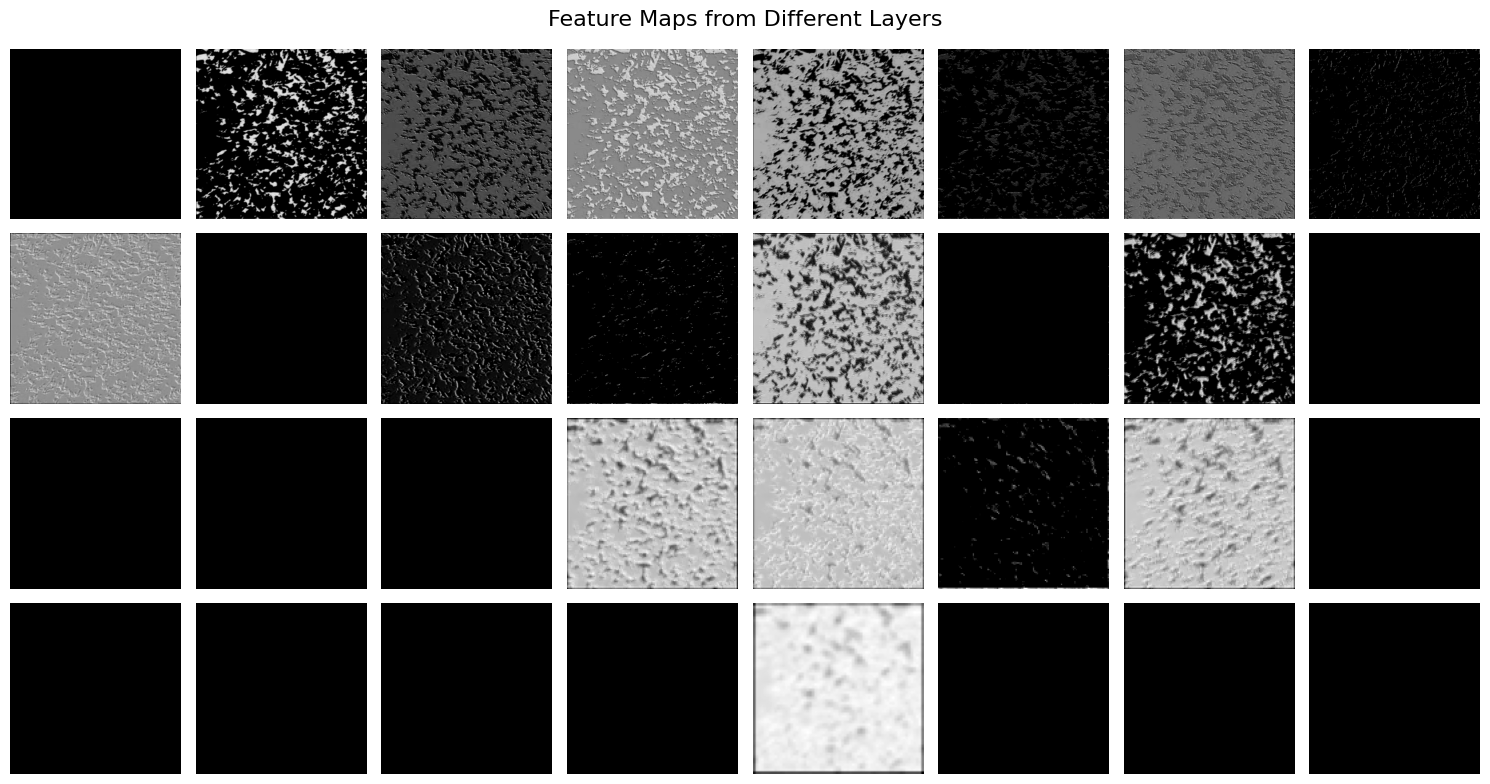

In [20]:
image, _ = dataset[0]  # Getting an image from the dataset
image = image.unsqueeze(0).to('cuda')
output, feature_maps = model(image, return_feature_maps=True)
visualize_feature_maps(feature_maps)

# CONV TEST

In [21]:
img = im.open('images\IMG_6704.JPEG')

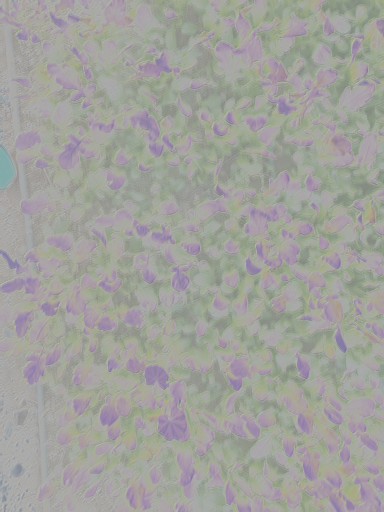

In [110]:
a = img.copy()
q = convolution(a, random_kernel(seed=156), resize=512)
q

[[-9.70787455e-01  4.20858767e-04  9.99579318e-01]
 [ 1.77122101e-07  8.06805948e-02  2.78804829e+00]
 [-9.70787455e-01  6.04228443e+01  4.20858767e-04]]


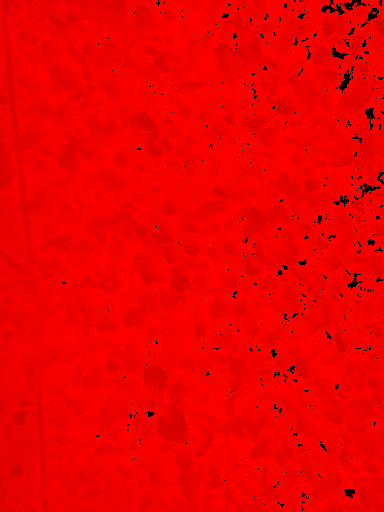

In [23]:
b = img.copy()
c = skimage.measure.shannon_entropy(b)
kernel = kernel_from_constant(random_kernel(seed=156), c)
print(kernel)
q = quick_convolution(b, kernel, resize=512)
q